In [138]:
import quandl
import math
import numpy as np
import pandas as pd
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import cross_validation
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

import datetime
import matplotlib.pyplot as plt
from matplotlib import style

In [139]:
style.use('ggplot')

In [173]:
df = quandl.get("WIKI/XOM", api_key="qrznzr7vcG1HMd7ae2E7")

df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
1970-01-02,61.75,62.00,61.62,62.00,36700.0,0.0,1.0,0.740936,0.743936,0.739376,0.743936,1174400.0
1970-01-05,62.00,63.00,61.87,63.00,58800.0,0.0,1.0,0.743936,0.755935,0.742376,0.755935,1881600.0
1970-01-06,63.00,63.13,62.25,62.87,38500.0,0.0,1.0,0.755935,0.757495,0.746936,0.754375,1232000.0
1970-01-07,62.87,62.87,62.38,62.50,28700.0,0.0,1.0,0.754375,0.754375,0.748496,0.749935,918400.0
1970-01-08,62.50,63.00,62.25,62.62,33600.0,0.0,1.0,0.749935,0.755935,0.746936,0.751375,1075200.0


In [174]:
df = df[['Adj. Open',  'Adj. High',  'Adj. Low',  'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

In [175]:
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
forecast_col = 'Adj. Close'
df.fillna(value=-99999, inplace=True)
forecast_out = int(math.ceil(0.01 * len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)

In [176]:
df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
1970-01-02,0.743936,0.612903,0.404858,1174400.0,0.674942
1970-01-05,0.755935,1.793651,1.612903,1881600.0,0.659943
1970-01-06,0.754375,1.399714,-0.206349,1232000.0,0.656943
1970-01-07,0.749935,0.784000,-0.588516,918400.0,0.656943
1970-01-08,0.751375,1.197700,0.192000,1075200.0,0.655384


In [177]:
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
forecast_col = 'Adj. Close'
df.fillna(value=-99999, inplace=True)
forecast_out = int(math.ceil(0.01 * len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)



In [178]:
df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
1970-01-02,0.743936,0.612903,0.404858,1174400.0,0.674942
1970-01-05,0.755935,1.793651,1.612903,1881600.0,0.659943
1970-01-06,0.754375,1.399714,-0.206349,1232000.0,0.656943
1970-01-07,0.749935,0.784000,-0.588516,918400.0,0.656943
1970-01-08,0.751375,1.197700,0.192000,1075200.0,0.655384


In [179]:
X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

df.dropna(inplace=True)

y = np.array(df['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [180]:
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)

In [181]:
forecast_set = clf.predict(X_lately)
df['Forecast'] = np.nan

In [182]:
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day



In [183]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]



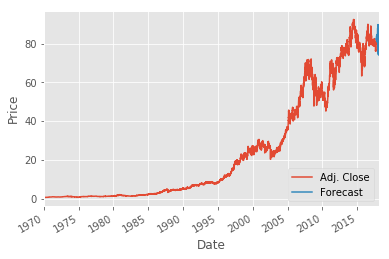

In [184]:
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()